In [537]:
import numpy as np
import pickle
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import seaborn as sns
from collections import defaultdict as ddict

import sys
sys.path.append('./../..')

import stationary_distribution_aug as sd
from mutator_classes import Parameters
from collections import namedtuple as nt
from copy import deepcopy
from collections import Counter

In [561]:
class SM_traj_results_object:
    def __init__(self,a):
        self.peak_prob = a[0]
        self.inner_color = a[1]
        self.outer_color = a[2]
        
class SM_set_results_object:
    def __init__(self,a):
        self.peak_prob = a[0]
        self.inner_color = a[1]
        self.outer_color = a[2]
        
class SM_results_object:
    def __init__(self,a):
        self.sets = SM_set_results_object(a[0])
        self.traj = SM_traj_results_object(a[1])
        self.peaks = a[2]
    
class HP_results_object:
    def __init__(self,a):
        self.prob = a[0]
        self.quantile = a[1]
    
class results_object:
    def __init__(self,a,S):
        self.HP = HP_results_object(a['HP'])
        self.SM = {'restricted':SM_results_object(a['restricted']),
                   'relaxed':SM_results_object(a['relaxed'])}
        

In [567]:
model = 'default' # choose between Default (Fig. 3 & Fig. S14), M100 (Fig. S13), fewer (Fig. S16), somatic (Fig. S17) or different (Fig. S15)

# load the results from a given model
in_path = f'/Users/will_milligan/Desktop/humanParams/{model}'
results = {}
for param_dir in os.listdir(in_path):
    
    if not os.path.isdir(os.path.join(in_path,param_dir)): continue
        
    S = 10**eval(param_dir.split('S')[-1])
    results[S] = {}
    
    param_dir_full = os.path.join(in_path,param_dir)
    
    for m_file in os.listdir(param_dir_full):
        try:
            M = eval(m_file.split('summarized_sample_statistics_')[-1].split('_')[0])
        except:
            print(m_file,param_dir)
        
        with open(os.path.join(param_dir_full,m_file),'rb') as fin:
            
            results[S][M] = results_object(pickle.load(fin),S)

In [541]:
### Figure info ###
mpl.rcParams['figure.dpi'] = 400
font_size = 10
mpl.rcParams['axes.titlesize'] = font_size
mpl.rcParams['axes.labelsize'] = font_size
mpl.rcParams['xtick.labelsize'] = font_size
mpl.rcParams['ytick.labelsize'] = font_size
mpl.rcParams['legend.fontsize'] = font_size
mpl.rcParams['legend.title_fontsize'] = font_size
inner_font_size = 8
sns.set_style('whitegrid')
cmap = mpl.cm.get_cmap('winter')

class Colors():
    blue = np.array([0,0,1])
    green = np.array([0,1,0])
    teal = np.array([0,0.5,0.5])
    
# get the prestored n vals
with open('/Users/will_milligan/PycharmProjects/Mutator_Project/Final Figs/expectedMaxM_trinucleotide.pickle','rb') as fin:
    (s_values_exp,nvals_exp) = pickle.load(fin)

In [559]:
# a bunch fo helper functions for making the graphs
def calc_size(prob):
    return 4*(5+np.log10(prob))**2

def calc_edgecolor(outer_color):
    
    if outer_color:
        return 'red'
    else:
        return 'k'

def get_dot_string(i):
    if i == 0:
        s = r'$10^{{\!}0}$'
    elif i == 1:
        s = r'$10^{{\!}{-}{\!}1}$'
    elif i == 2:
        s = r'$10^{{\!}{-}{\!}2}$'
    elif i == 3:
        s = r'$10^{{\!}{-}{\!}3}$'
    else:
        s = r'$\leq \! 10^{{\!}{-}{\!}4}$'
    return s

def dot_legend(axes,title = 'Probability of peak-like',x_title = 16e-2):        
    x_scaling = 1
    if model == 'default':
        scaling = 1
    elif model == 'somatic':
        scaling = 2
        x_scaling = 1/2
    elif model == 'fewer':
        scaling = 1
    elif model == 'different':
        scaling = 1/np.mean([5]*4+[0.5]*4+[1]*88)*14000/20000
        
    x = 1e-2*x_scaling
    for prob in [5,4,3,2,1]:
        axes.scatter(x,1000*scaling,color='k',s = calc_size(10**(prob-5)))
        s = get_dot_string(5-prob)
        axes.text(x,650*scaling,s,
              horizontalalignment='center',
              verticalalignment='center',
              fontsize = inner_font_size)
        x = x * 3.75
        
    axes.text(x_title,
              1400*scaling,
                title,
                horizontalalignment='center',
                fontsize = 9)
    
    
def edge_color_legend(axes,unit): # legend for what edgecolor means
    x_scaling = 1
    if model == 'default':
        scaling = 1
    elif model == 'somatic':
        scaling = 2
        x_scaling = 1/2
    elif model == 'fewer':
        scaling = 1
    elif model == 'different':
        scaling = 1/np.mean([5]*4+[0.5]*4+[1]*88)*14000/20000
        
    x = 0.8e-2*x_scaling
    y = 400*scaling
    for color,label in zip(['k','r'],[f'Most{unit} not-peaked',f'Most{unit} multi-elevated']):
        axes.scatter(x,y,color=[0,0,0,0],edgecolor=color,s = 60)
        if model == 'somatic':
            edge_fontsize = 8.7
        else:
            edge_fontsize = 9
        axes.text(x*1.5,y,label,verticalalignment='center',fontsize = edge_fontsize)
        y = y - 150*scaling
        
def colorbar_legend(ax_cbar,norm,cbar_title,extend='neither'):
        # colorbar legend for what facecolor means
    cbl = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical',
                                    extend=extend)
    cbl.set_label(cbar_title,labelpad = -0.2)
    ax_cbar.tick_params(axis='both', which='major', pad=1)
#     cbl.ax.set_yticklabels(['1', '2', '3+'])
    cbl.outline.set_edgecolor('k')
    return cbl
    
def axes_modifications(axes,title,text_y=5,labelM=False,nvals_exp=nvals_exp,s_values_exp=s_values_exp):

    axes.spines['bottom'].set_color('k')
    axes.spines['top'].set_color('k')
    axes.spines['left'].set_color('k')
    axes.spines['right'].set_color('k')
    axes.tick_params(left=True,bottom=True,which='both')
    axes.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    if model == 'somatic':
        axes.set_xlabel('Scaled selection parameter ' + r'$\left(8NLhs\phi\right)$',labelpad=0.5)
    else:
        axes.set_xlabel('Scaled selection parameter ' + r'$\left(4NLhs\phi\right)$',labelpad = 0.5)
    axes.set_ylabel('Number of modifier sites',labelpad = -0.5)
    axes.set_xlim([0.5e-2,2e3])
    
    axes.set_xscale('log')
    axes.set_yscale('log')
    axes.grid(color=[0.9,0.9,0.9,0])
    axes.set_title(title)
    axes.set_xticks(np.logspace(-2,3,6))
    
    x_scaling = 1
    
    if model == 'default':
        scaling = 1
        axes.set_ylim([0.8e0,2e3])
        
    elif model == 'somatic':
        scaling = 2
        x_scaling = 1/2
        axes.set_xlim([0.25e-2,2e3])
        axes.set_ylim([0.8e0,4.25e3])
        s_values_exp = s_values_exp*x_scaling
        s_accepted = np.where(s_values_exp>=1e-2)[0]
        s_values_exp = s_values_exp[s_accepted]
        nvals_exp = nvals_exp[s_accepted]
        
    elif model == 'fewer':
        axes.set_ylim([0.8e0,2e3])
        scaling = 1
        
    elif model == 'different':
        axes.set_ylim([0.8e0,1.3e3])
        scaling = 1/np.mean([5]*4+[0.5]*4+[1]*88)*14000/20000
        
    axes.plot(s_values_exp,nvals_exp*scaling,color='grey',zorder=1)
#     axes.text(10**(-1.9),text_y=7,'Max. Number of Modifier Sites',rotation=-57,color='grey',zorder=1,fontsize=6)
    if labelM:
        if model == 'somatic':
            Mtext = 'Max. # of modifiers'
            axes.text(10**(-2),text_y*scaling,Mtext,rotation=-53,color='grey',zorder=1,fontsize=9)
        elif model == 'M100':
            Mtext = 'Max. # of modifiers'
            axes.text(10**(-2),text_y*2,Mtext,rotation=-57,color='grey',zorder=1,fontsize=9)
        elif model == 'fewer':
            Mtext = 'Max. # of modifiers'
            axes.text(10**(-2),text_y*2,Mtext,rotation=-57,color='grey',zorder=1,fontsize=9)
        elif model == 'different':
            Mtext = 'Max. # of modifiers'
            axes.text(10**(-2),text_y+2,Mtext,rotation=-57,color='grey',zorder=1,fontsize=9)
        else:
            Mtext = 'Max. # of modifiers'
#             axes.text(10**(-2)*x_scaling,text_y,Mtext,rotation=-57,color='grey',zorder=1,fontsize=9)
            axes.text(10**(-2),text_y*2,Mtext,rotation=-57,color='grey',zorder=1,fontsize=9)
        

In [543]:
# plot the panel for the individual trajectories
def traj_figure(fig,
                axes,
                ax_cbar,
                results,
                mode = 'restricted',
               labelM = True):
    
    min_value = 1e-5
    max_value = 1
    norm = mpl.colors.LogNorm(vmin=min_value, vmax=max_value,clip=True)
    
    for S,Sdict in results.items():
        for M,results_object in Sdict.items():
            
            if results_object.SM[mode].traj.peak_prob == 0:
                size = 4
                
            else:
                size = calc_size(results_object.SM[mode].traj.peak_prob)
                
                if size > 10000 or size <= 4:
                    size = 4
                
            inner_color = cmap(norm(max(min_value,results_object.SM[mode].traj.inner_color)))
            outer_color = calc_edgecolor(results_object.SM[mode].traj.outer_color)
                
            axes.scatter(S,M,s=size,marker='o',color=inner_color,edgecolor=outer_color,zorder=2)

            
    dot_legend(axes = axes)
    
    edge_color_legend(axes = axes,
                      unit = '')

    cbl = colorbar_legend(ax_cbar = ax_cbar,
                    norm = norm,
                    cbar_title = "Proportion of trajectories multi-elevated",
                    extend = 'min')

    axes_modifications(axes = axes,
                       title = r'$\bf{A.}$ Categorization of individual trajectories',
                      labelM=labelM)

In [551]:
# plot the panel for the sets of trajectories
def sets_figure(fig,
                axes,
                ax_cbar,
                results,
                mode = 'restricted'):
    
#     norm = mpl.colors.Normalize(vmin=1, vmax=25)
    min_value = 1
    max_value = 25
    norm = mpl.colors.LogNorm(vmin=min_value, vmax=max_value,clip=False)
    
    for S,Sdict in results.items():
        for M,results_object in Sdict.items():
            if results_object.SM[mode].sets.peak_prob == 0:
                size = 4
            else:
                size = calc_size(results_object.SM[mode].sets.peak_prob)
    #             print(S,M,results_object.SM[mode].sets.peak_prob)

                if size > 10000 or size <= 1:
                    size = 4
            if size == 4:
                inner_color = [1,1,1,1]
            else:
                inner_color = cmap(norm(results_object.SM[mode].sets.inner_color))
                
            outer_color = calc_edgecolor(not results_object.SM[mode].sets.outer_color)
        
#             if results_object.SM[mode].sets.inner_color > 5:
#                 print(results_object.SM[mode].sets.inner_color)
            axes.scatter(S,M,s=size,marker='o',color=inner_color,edgecolor=outer_color,zorder=2)
            
    dot_legend(axes = axes)
    
    edge_color_legend(axes = axes,
                      unit = '')

    cbl = colorbar_legend(ax_cbar = ax_cbar,
                    norm = norm,
                    cbar_title = "Number of peak-like trajectories per set")

    axes_modifications(axes = axes,
                       title = r'$\bf{B.}$ Categorization of sets of 96 trajectories')

In [545]:
# plot the panel for the pirtchard harris results
def PH_figure(fig,
              axes,
              ax_cbar,
              results, 
              text_y, 
              title = r'$\bf{C.}$ Harris-Pritchard Enrichments',
              x_title = 0.5,
              mode = 'restricted'):
    
    min_HP = 1.01
    max_HP = 11
    norm = mpl.colors.LogNorm(vmin=min_HP-1, vmax=max_HP,clip=True)
    
    for S,Sdict in results.items():
        for M,results_object in Sdict.items():
            if results_object.HP.prob == 0:
                size = 4
            else: 
                size = calc_size(results_object.HP.prob)
                
                if size > 10000 or size <= 1:
                    size = 4
                
            if results_object.HP.quantile > max_HP:
                print(results_object.HP.quantile)
                
            inner_color = cmap(norm(results_object.HP.quantile-1))
                
            outer_color = 'k'
                
            axes.scatter(S,M,s=size,marker='o',color=inner_color,edgecolor=outer_color,zorder=2)

    dot_legend(axes,title = 'Probability of enrichment > 1.1',x_title = x_title)
    cbl = colorbar_legend(ax_cbar=ax_cbar,
                    norm = norm,
                    cbar_title = "95% Quantile",
                    extend='min')

    axes_modifications(axes,title = title,text_y = text_y)
    cbl.ax.set_yticklabels(['1.01','1.1','2','11'])

    plt.subplots_adjust(wspace=0.05)


In [546]:
def get_intersection_polygon(results,threshold = 1e-2,mode_list=['restricted']):
    
    passing_points_intersection = {mode:[] for mode in mode_list}
    
    for mode in mode_list:
        for S,Sdict in results.items():
            for M,results_object in Sdict.items():
                if results_object.SM[mode].sets.peak_prob > threshold and results_object.HP.prob > threshold:
                    passing_points_intersection[mode].append((S,M))
                    
    return passing_points_intersection

def simple_intersection_plot(ax, points):
    
    
    for mode,points_list in points.items():
        if mode == 'relaxed':
            color = 'grey'
            marker = 'o'
        elif mode == 'restricted':
            color ='k'
            marker = '.'
        for (x,y) in points_list:
            ax.scatter(x,y,marker=marker,color=color)
    
    for mode in ['restricted','relaxed']:
        if mode == 'relaxed':
            color = 'grey'
            marker = 'o'
            label = 'Relaxed'
        elif mode == 'restricted':
            color ='k'
            marker = '.'
            label = 'Restricted'
        ax.plot([],[],marker=marker,color=color,label=label,ls='None')

    axes_modifications(ax, title = r'$\bf{D.}$ Intersection where both enrichments occur in $\geq 1\%$ of sets')
    if model == 'different':
        loc = 'upper left'
    else:
        loc = 'upper left'
    ax.legend(loc = loc,edgecolor='k',framealpha=1,title='Peak-like def.',handletextpad=0.2)


In [547]:
def intersection_figure(ax, x_all,y_all,x_PH=[],y_PH=[],x_SM=[],y_SM=[]):
    
    for x,y in zip(x_all,y_all):
        ax.fill(x,y,facecolor=[0.5]*4, edgecolor='k', linewidth=2)
    ax.fill(x_SM,y_SM,facecolor='blue',alpha=0.1,edgecolor='k', linewidth=2)
    ax.fill(x_PH,y_PH,facecolor='red',alpha=0.1,edgecolor='k', linewidth=2)
    axes_modifications(ax, title = r'$\bf{D.}$ Intersection where both enrichments occur in $\geq 1\%$ of sets')
    

In [548]:
# Fig. 3D
def make_fake_traj(ax):

    x_values = np.sort(np.append(np.linspace(0,13,14),np.linspace(1,14,14)))
    elevated_threshold = 1.1
    peak_threshold = 1.3
    max_height = 1.4
    u0 = 1
    min_height = 0.95
    color1 = [0.1,0.2,1]
    color2 = [0.05,0.7,0.3]
    peak_color = 'r'
    elevated_color = [0.85,0.4,0]
    not_peak = 2
    peak_like = 1
    buffer_weight = 0.95
    multi_peak = 0
    
    ax.set_ylim(min_height,min_height+(max_height - min_height)*3+0.1)
    ax.set_xlim(0,14)
    ax.grid(False)
    
    no_peak = []
    for i in range(14):
        v = np.random.random()*(elevated_threshold-u0)+u0+(max_height-min_height)*not_peak*0.97
        no_peak.append(v)
        no_peak.append(v)
    no_peak[8] = 1.07+(max_height-min_height)*not_peak
    no_peak[9] = 1.07+(max_height-min_height)*not_peak
    ax.plot(x_values,no_peak,color=color2,alpha=1)
    
    no_peak = []
    for i in range(14):
        v = np.random.random()*(elevated_threshold*buffer_weight-u0)+u0+(max_height-min_height)*not_peak
        no_peak.append(v)
        no_peak.append(v)
    no_peak[4] = 1.2+(max_height-min_height)*not_peak
    no_peak[5] = 1.2+(max_height-min_height)*not_peak
    ax.plot(x_values,no_peak,color=color1,alpha=1)
    
    peak = []
    for i in range(14):
        v = np.random.random()*(elevated_threshold*buffer_weight-u0)+u0+(max_height-min_height)*peak_like
        peak.append(v)
        peak.append(v)
    peak[24] = 1.35 + (max_height-min_height)*peak_like
    peak[25] = 1.35 + (max_height-min_height)*peak_like
    ax.plot(x_values,peak,color=color1,alpha=1)
    
    multi_1 = []
    for i in range(14):
        v = np.random.random()*(elevated_threshold-u0)+u0+(max_height-min_height)*multi_peak
        multi_1.append(v)
        multi_1.append(v)
    multi_1[8] = 1.22 + (max_height-min_height)*multi_peak
    multi_1[9] = 1.22 + (max_height-min_height)*multi_peak
    
    multi_1[18] = 1.15 + (max_height-min_height)*multi_peak
    multi_1[19] = 1.15 + (max_height-min_height)*multi_peak
    ax.plot(x_values,multi_1,color=color1,alpha=1)
    
    multi_2 = []
    for i in range(7):
        v = np.random.random()*(elevated_threshold-u0)+u0+(max_height-min_height)*multi_peak
        multi_2.append(v)
        multi_2.append(v)
    v_set = np.array([0,0.1,0.12,0.25,0.22,0.35,0.1])+u0+(max_height-min_height)*multi_peak
    for v in v_set:
        multi_2.append(v)
        multi_2.append(v)
    ax.plot(x_values,multi_2,color=color2,alpha=1)
    
    hlines = []
    for i in range(3):
        for v in [elevated_threshold,peak_threshold, max_height]:
            hlines.append(v+(max_height-min_height)*i)
            
    ax.hlines(hlines,xmin=0,xmax=14,colors=[elevated_color,peak_color,'k']*3,ls=[':','--','-']*3)
    ax.axes.xaxis.set_ticks([])#set_visible(False)
    ax.axes.yaxis.set_ticks([])#visible(False)
    
    ax.vlines([7],ymin=min_height,ymax = min_height+0.15+(max_height - min_height)*3,zorder=1000,color='k',alpha=0.25)
    
    ax.spines['bottom'].set_color('k')
    ax.spines['top'].set_color('k')
    ax.spines['left'].set_color('k')
    ax.spines['right'].set_color('k')
    
    ax.set_ylabel('Average mutation rate in window')
    ax.set_xlabel('Time (log)')
    
    ax.text(y=((max_height-min_height)*2+1.12),x = 7.1, s = 'Elevated threshold',color = elevated_color,size=9)
    ax.text(y=((max_height-min_height)*2+1.22),x = 7.1, s = 'Peak threshold',color =peak_color,size=9)
    ax.text(y=((max_height-min_height)*multi_peak+1.32),x = 0.15, s = 'Multi-elevated - Multiple elevated',size=9,color='k')
    ax.text(y=((max_height-min_height)*peak_like+1.32),x = 0.15, s = 'Peak-like - One elevated & peaked',size=9,color='k')
    ax.text(y=((max_height-min_height)*not_peak+1.32),x = 0.15, s = r'Not-peaked - $\leq 1$ elevated & none peaked',size=9,color='k')
    ax.text(y=((max_height-min_height)*3+min_height+0.025),x = 3.5, s = 'Population A',size=9,color='k',ha='center')
    ax.text(y=((max_height-min_height)*3+min_height+0.025),x = 10.5, s = 'Population B',size=9,color='k',ha='center')
    ax.text(y=((max_height-min_height)*2+1.22),x = 2.5, s = 'Ex. traj. 1',size=9,color=color1,ha='center')
    ax.text(y=((max_height-min_height)*2+1.13),x = 4.6, s = 'Ex. traj. 2',size=9,color=color2,ha='center')
    ax.set_title(r'$\bf{D.}$ Categories of mutation rate trajectories')

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


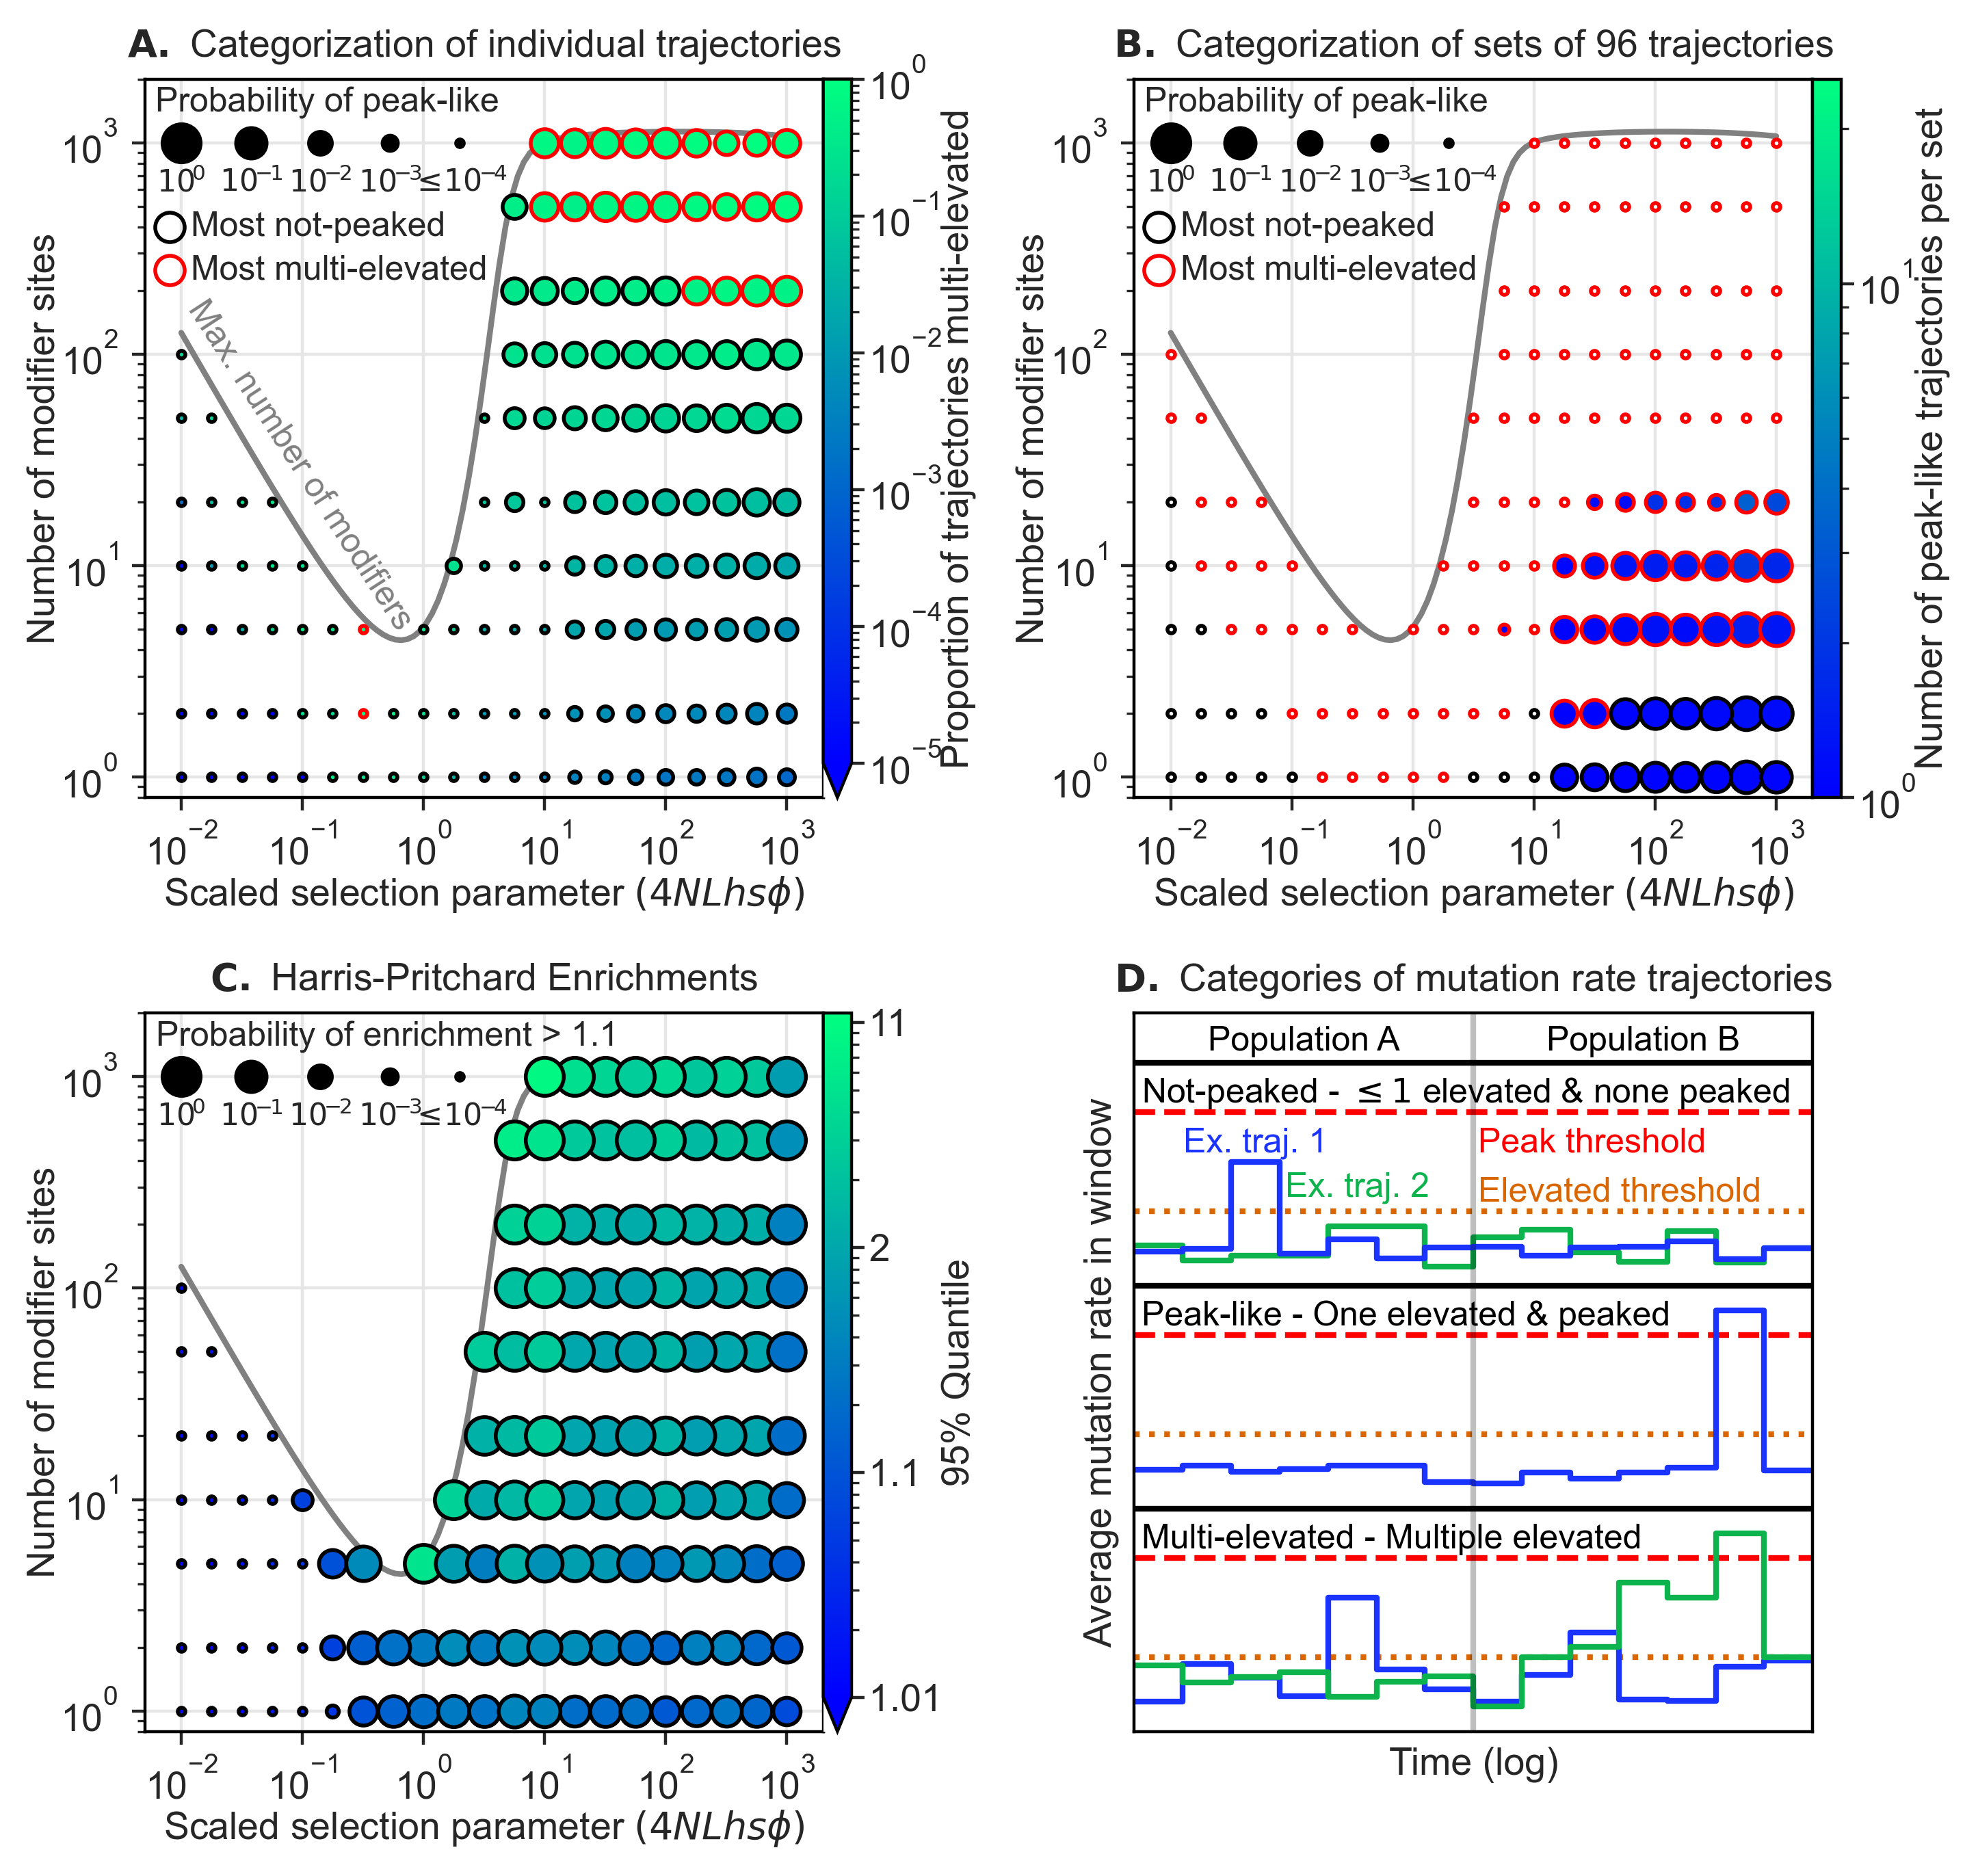

In [552]:
# Figure 3
if model == 'default':
    mode = 'restricted'

    fig, [[axes,ax_cbar,spacer1,axes2,ax_cbar2],
          [axes3,ax_cbar3,spacer2,axes4,spacer3]] = plt.subplots(nrows=2,
                                                                 ncols=5,
                                                                 figsize=(8,8),
                                                                 gridspec_kw={'width_ratios': [24, 1,10,24,1]})
    spacer1.axis('off')
    spacer2.axis('off')
    spacer3.axis('off')

    sets_figure(fig = fig,
                axes = axes2,
                ax_cbar = ax_cbar2,
                results = results,
                mode = mode)

    traj_figure(fig = fig,
                axes = axes,
                ax_cbar = ax_cbar,
                results = results,
                mode = mode)

    PH_figure(fig=fig, 
                axes=axes3,
                ax_cbar=ax_cbar3,
                results = results,
                text_y = 5,
                mode = mode)

    make_fake_traj(axes4)

    plt.subplots_adjust(wspace=0,hspace=0.3)
    plt.savefig('/Users/will_milligan/Desktop/MutatorFigures/Fig3.pdf',dpi=400,bbox_inches='tight')

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


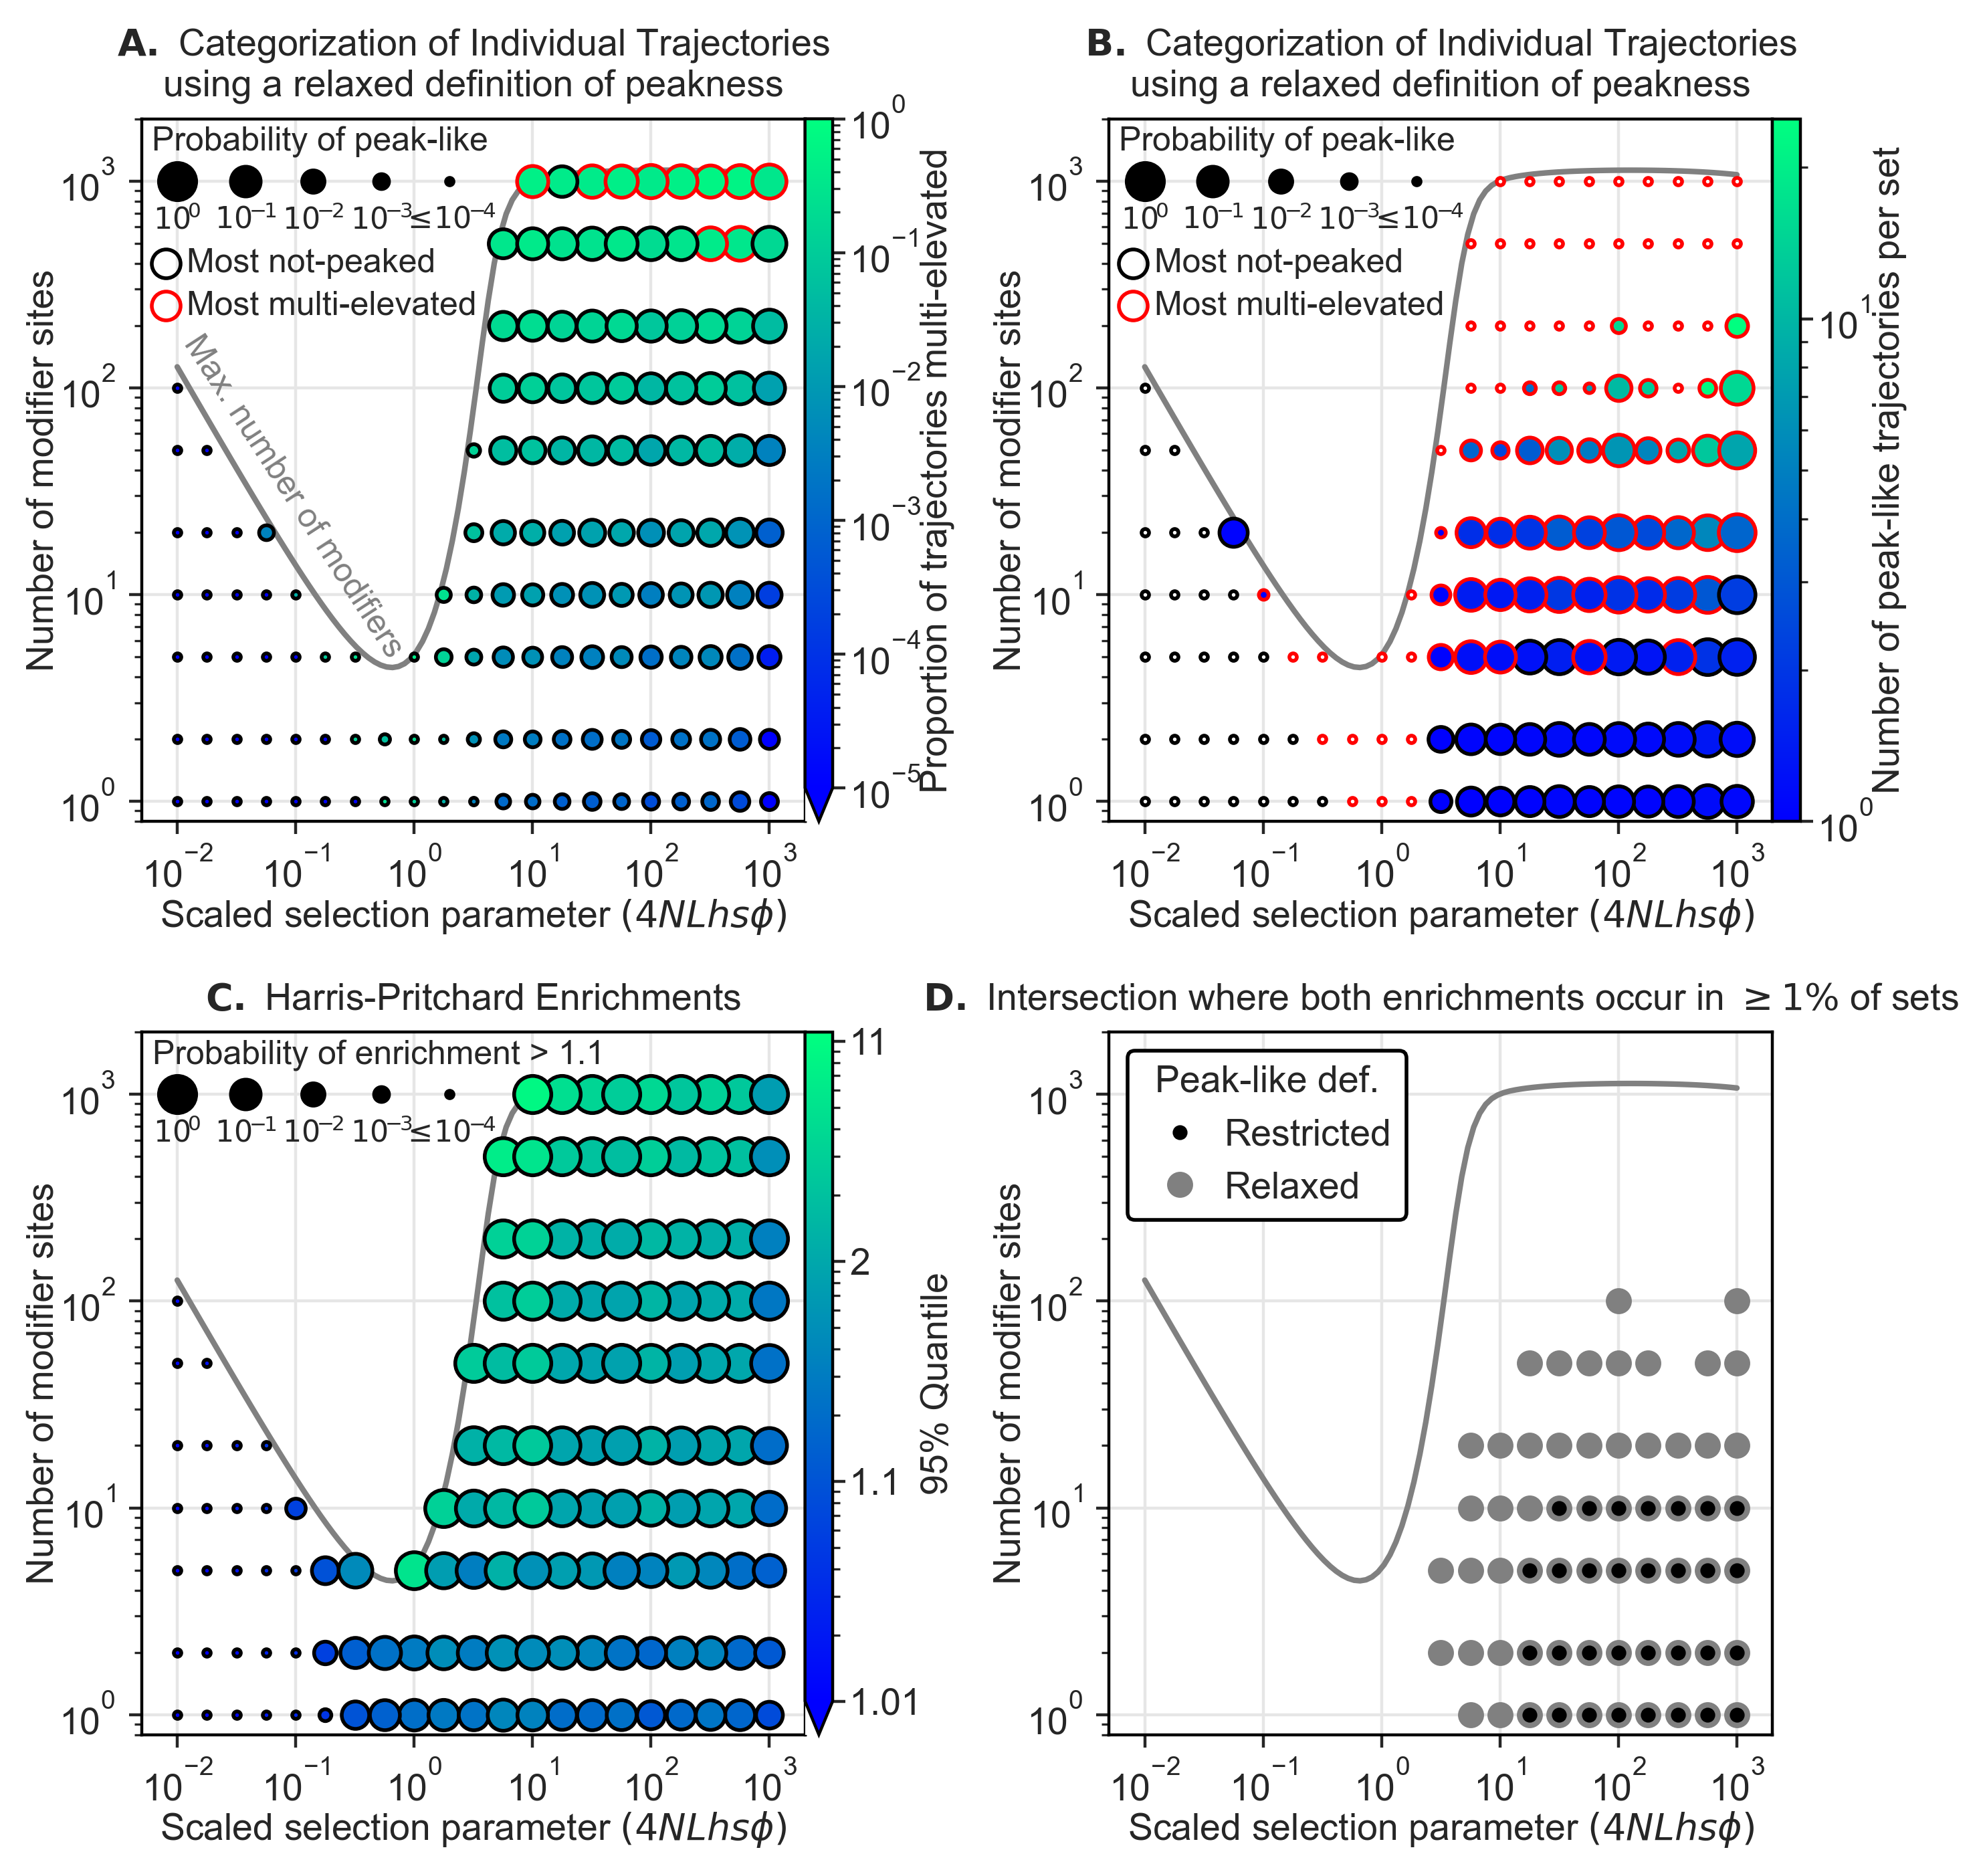

In [553]:
# Fig S14
if model == 'default':
    
    mode = 'relaxed'

    fig, [[axes,ax_cbar,spacer1,axes2,ax_cbar2],
          [axes3,ax_cbar3,spacer2,axes4,spacer3]] = plt.subplots(nrows=2,
                                                                 ncols=5,
                                                                 figsize=(8,8),
                                                                 gridspec_kw={'width_ratios': [24, 1,10,24,1]})
    spacer1.axis('off')
    spacer2.axis('off')
    spacer3.axis('off')

    SM_passing_points = sets_figure(fig = fig,
                                    axes = axes2,
                                    ax_cbar = ax_cbar2,
                                    results = results,
                                    mode = mode)

    traj_figure(fig = fig,
                axes = axes,
                ax_cbar = ax_cbar,
                results = results,
                mode = mode)

    PH_passing_points = PH_figure(fig=fig, 
                                  axes=axes3,
                                  ax_cbar=ax_cbar3,
                                  results = results,
                                  text_y = 5,
                                    mode = mode)

    points = get_intersection_polygon(results,mode_list=['relaxed','restricted'])
    simple_intersection_plot(axes4,points)
    with open(f'./passing_points_{model}.pickle','wb+') as fout:
        pickle.dump(points,fout)

    axes.set_title(r'$\bf{A.}$ Categorization of Individual Trajectories' + '\n' + 'using a relaxed definition of peakness')
    axes2.set_title(r'$\bf{B.}$ Categorization of Individual Trajectories' + '\n' + 'using a relaxed definition of peakness')
    axes3.set_title(r'$\bf{C.}$ Harris-Pritchard Enrichments')
    axes4.set_title(r'$\bf{D.}$ Intersection where both enrichments occur in $\geq 1\%$ of sets')

    plt.subplots_adjust(wspace=0,hspace=0.3)

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


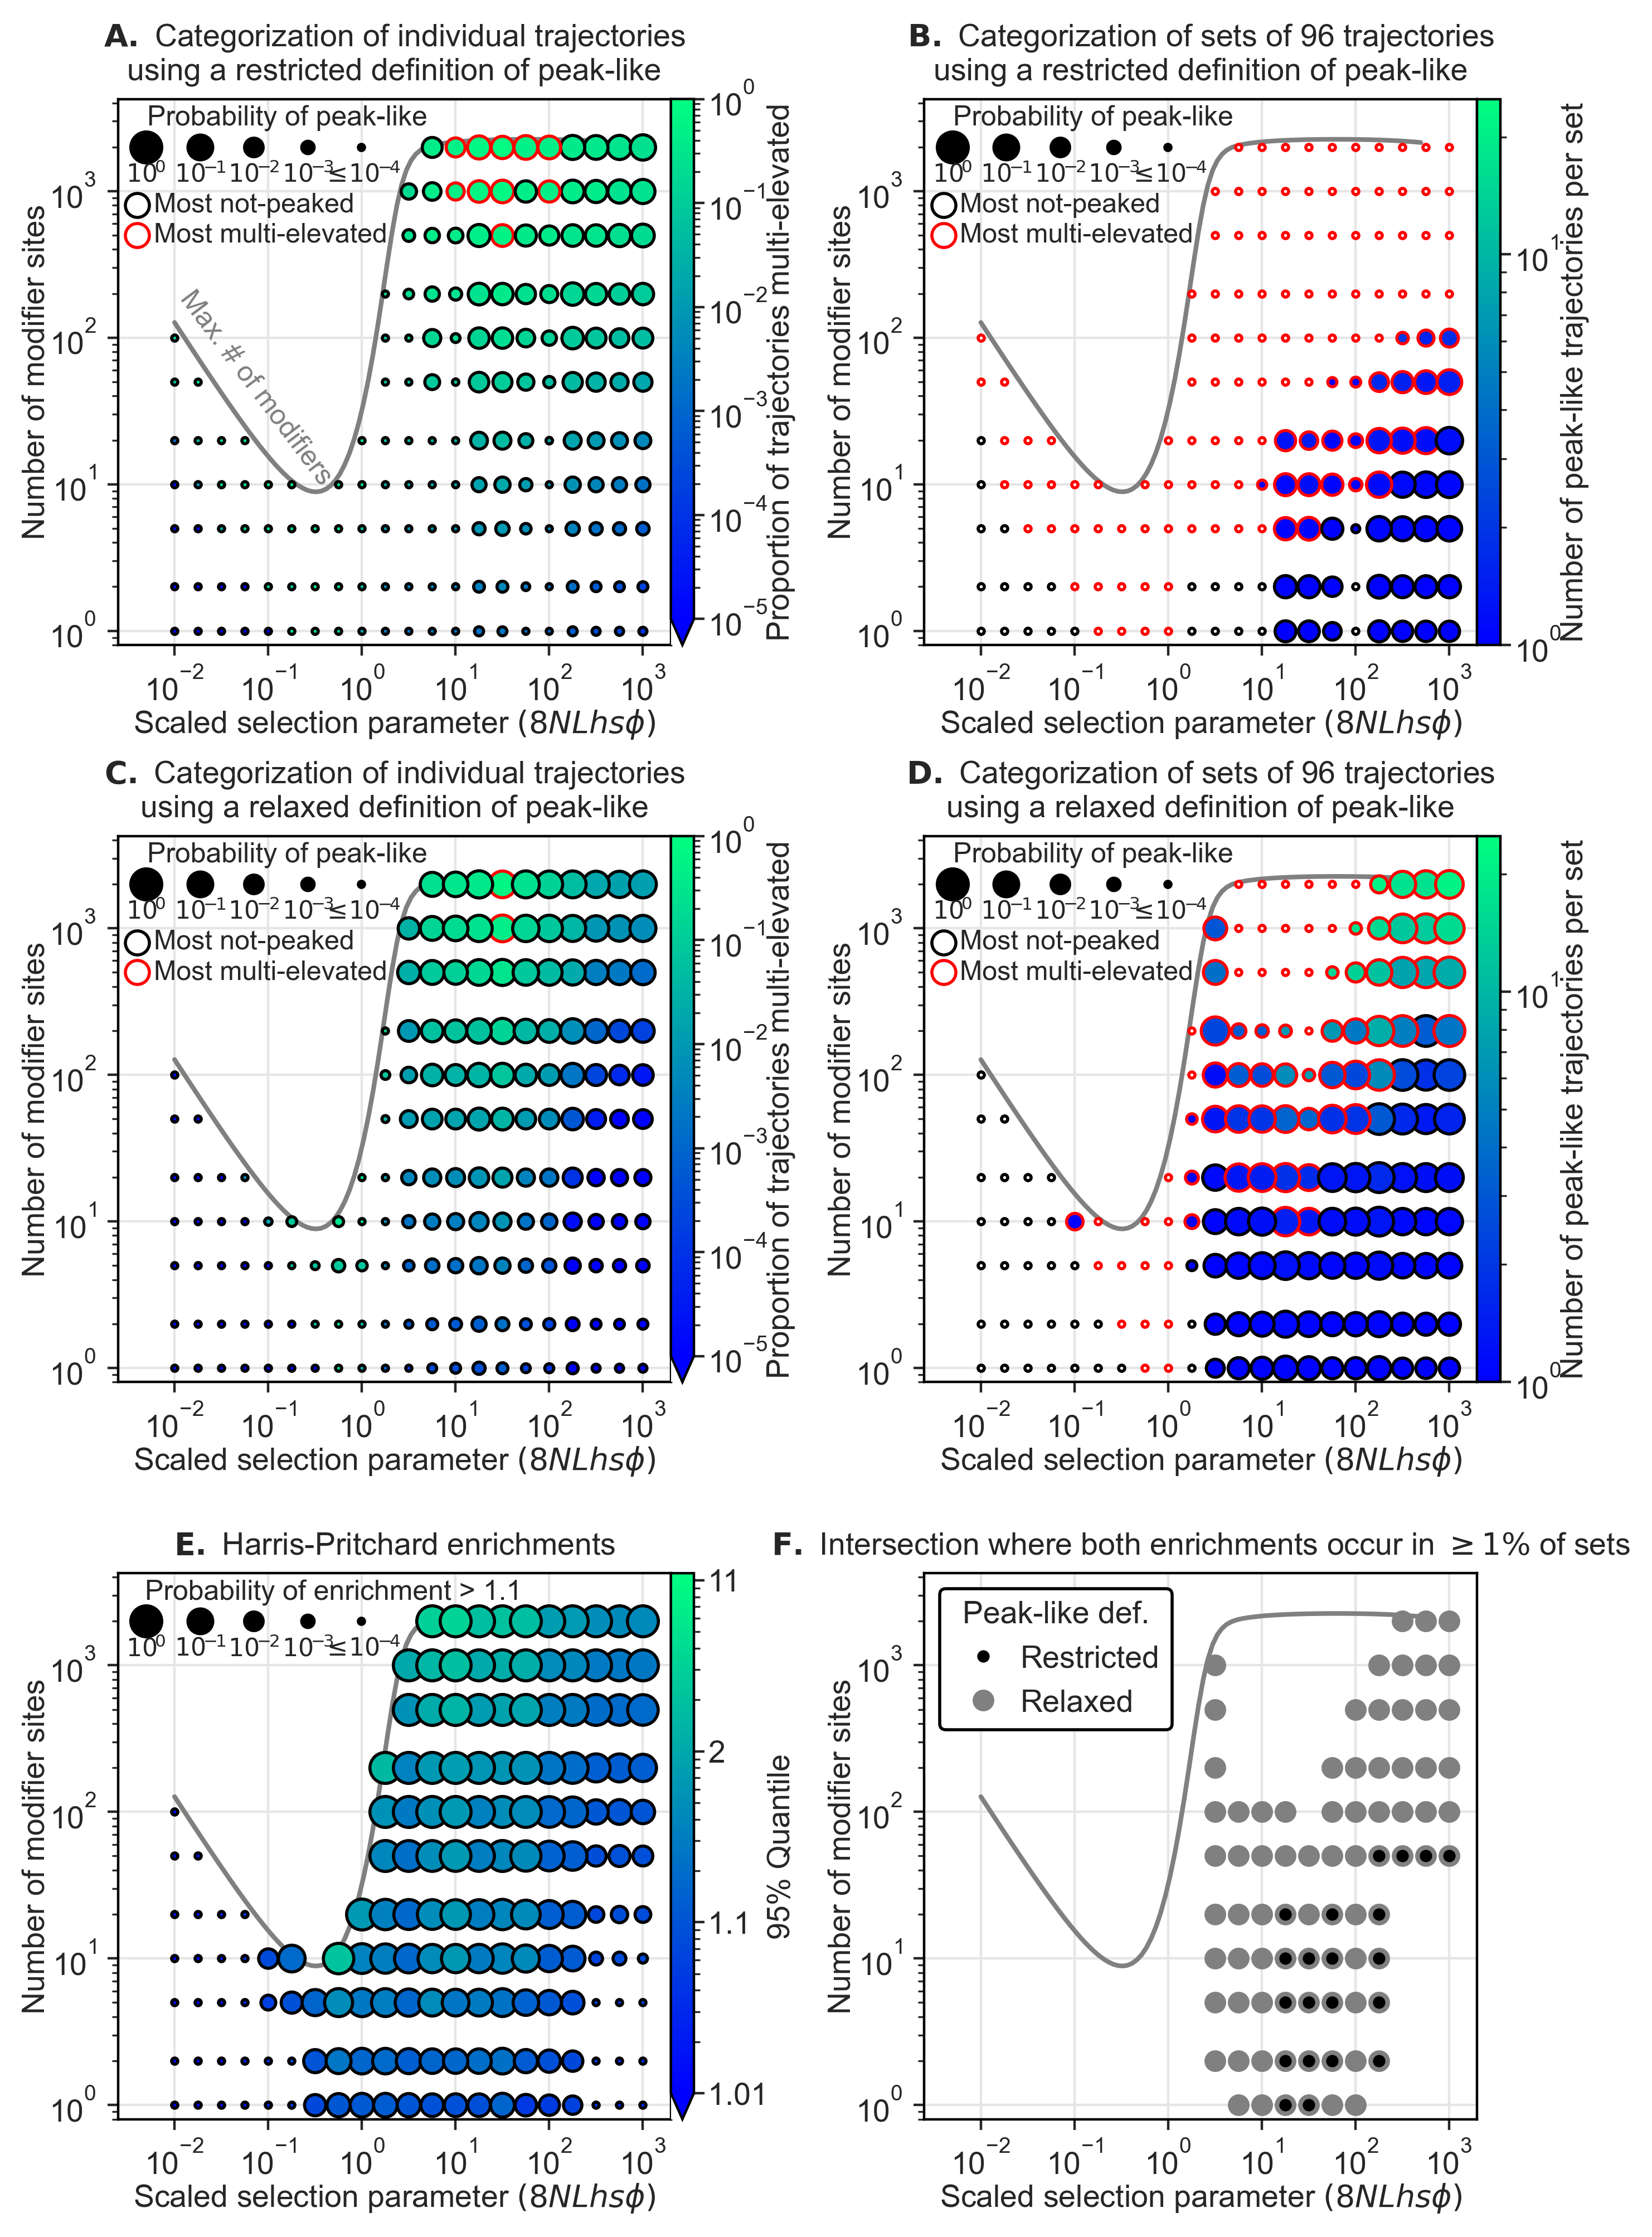

In [568]:
# Fig S13, Figs S15-17
if model != 'default':
    fig, axes = plt.subplots(nrows=3,
                                                                 ncols=5,
                                                                 figsize=(8,12),
                                                                 gridspec_kw={'width_ratios': [24, 1,10,24,1]})

    [[ax,ax_cbar,spacer1,ax2,ax_cbar2],
    [ax3,ax_cbar3,spacer2,ax4,ax_cbar3],
    [ax5,ax_cbar5,spacer3,ax6,spacer4]] = axes

    spacer1.axis('off')
    spacer2.axis('off')
    spacer3.axis('off')
    spacer4.axis('off')

    for mode,ax_row in (['restricted',axes[0]],['relaxed',axes[1]]):

        [ax_traj,ax_traj_cbar,trash,ax_set,ax_set_cbar] = ax_row

        sets_figure(fig = fig,
                    axes = ax_set,
                    ax_cbar = ax_set_cbar,
                    results = results,
                    mode = mode)

        traj_figure(fig = fig,
                    axes = ax_traj,
                    ax_cbar = ax_traj_cbar,
                    results = results,
                    mode = mode,
                    labelM = (mode == 'restricted'))

    PH_passing_points = PH_figure(fig=fig, 
                                  axes=ax5,
                                  ax_cbar=ax_cbar5,
                                  results = results,
                                  text_y = 5,
                                  mode = mode)

    points = get_intersection_polygon(results,mode_list=['relaxed','restricted'])
    simple_intersection_plot(ax6,points)
    with open(f'./passing_points_{model}.pickle','wb+') as fout:
        pickle.dump(points,fout)

    ax.set_title( r'$\bf{A.}$ Categorization of individual trajectories'  + '\n' + 'using a restricted definition of peak-like')
    ax2.set_title(r'$\bf{B.}$ Categorization of sets of 96 trajectories' + '\n' + 'using a restricted definition of peak-like')
    ax3.set_title(r'$\bf{C.}$ Categorization of individual trajectories' + '\n' + 'using a relaxed definition of peak-like')
    ax4.set_title(r'$\bf{D.}$ Categorization of sets of 96 trajectories' + '\n' + 'using a relaxed definition of peak-like')
    ax5.set_title(r'$\bf{E.}$ Harris-Pritchard enrichments')
    ax6.set_title(r'$\bf{F.}$ Intersection where both enrichments occur in $\geq 1\%$ of sets')

    plt.subplots_adjust(wspace=0,hspace=0.35)

In [519]:
# Fig S18

def peak_ax_modifications(axes,title,text_y=5):

    axes.spines['bottom'].set_color('k')
    axes.spines['top'].set_color('k')
    axes.spines['left'].set_color('k')
    axes.spines['right'].set_color('k')
    axes.tick_params(left=True,bottom=True,which='major')
    axes.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

    axes.set_xscale('log')
    axes.set_ylim([-0.05,1.05e0])
    axes.grid(color=[0.9,0.9,0.9,0])
    axes.set_title(title)
        
# function to define bins
def bin_index(S):
    
    if S <= 10:
        return 0
    elif S <= 100:
        return 1
    else:
        return 2
    
def peaks_figure(fig,
                axes,
                results_raw,
                mode = 'restricted',
                reverse = False,
                n_bins = 3,
                threshold = 0.01,
                cmap_list = [[i/3,i,i] for i in [0.9,0.6,0]],
                jitter = 0.075):
    # unpack axes
    ax1,ax2 = axes

    marker = '.'
    markersize = 6
    
    x_values = np.logspace(np.log10(60),4,8)
    # keep tracks of total number of peak trajectories. First index (key) is bin value, second is population, and third is peak location
    binned_y_values = ddict(lambda: [np.zeros(8),np.zeros(8)])
    
    for index,(S, Sdict) in enumerate(results.items()):
        
        # determine bin
        if S < 1: continue
        i = bin_index(S)
        
        # objects to record where peaks occur for this value of S
        CEU_values = np.zeros(8)
        YRI_values = np.zeros(8)
        
        # iterate over values of M
        for M, results_object in Sdict.items():
               
            # determine if this combination of M and S passes tests
            if results_object.SM[mode].sets.peak_prob < threshold or results_object.HP.prob < threshold : continue
            
            # Record where peaks occur for this combination of S and M
            for location,amount in results_object.SM[mode].peaks.items():
                
                # locations < 7 occur with CEU while others occur with YRI
                if location < 7:
                    CEU_values[location] += amount
                else:
                    YRI_values[location-7] += amount
        
        # store results based on bin
        binned_y_values[i][0] += CEU_values
        binned_y_values[i][1] += YRI_values
        
    #  plot binned results     
    for i,(CEU_values,YRI_values) in binned_y_values.items():

        # get color for this bin
        color = cmap_list[i]

        # for both populations...
        for y_values,ax in [(CEU_values,ax1),(YRI_values,ax2)]:
            
            # and each possible peak timing...
            for ii in range(7):
                
                # determine bin edge
                temp_x = np.logspace(np.log10(x_values[ii]),np.log10(x_values[ii+1]),9)
                x_right = temp_x[2*(i+2)-1]
                x_left = temp_x[2*(i+1)-1]

                # and bin height
                height = y_values[ii]/sum(y_values[:-1])
                
                # then plot it
                ax.bar(x = x_left,width = x_right-x_left,height = height,align='edge',color=color,edgecolor=[0,0,0,0])
    
    # do some modifications
    for ax in [ax1,ax2]:   
        
        peak_ax_modifications(ax,title='')
        ax.set_xticks(x_values)
        ax.set_xlim([min(x_values),max(x_values)])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([str(int(i)) for i in x_values],rotation=-45)
    ax1.fill_between([1.5e4/30,8e4/30],[-2]*2,[2]*2,color=[0.8,0.55,0.55,0.6])#,facecolor=[0,0,0,0],hatch="\\\\\\\\\\\\")
    ax1.fill_between([1e4/30,3e4/30],[-2]*2,[2]*2,color=[0.4,0.6,0.8,0.6])#,facecolor=[0,0,0,0],hatch="//////")

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in double_scalars


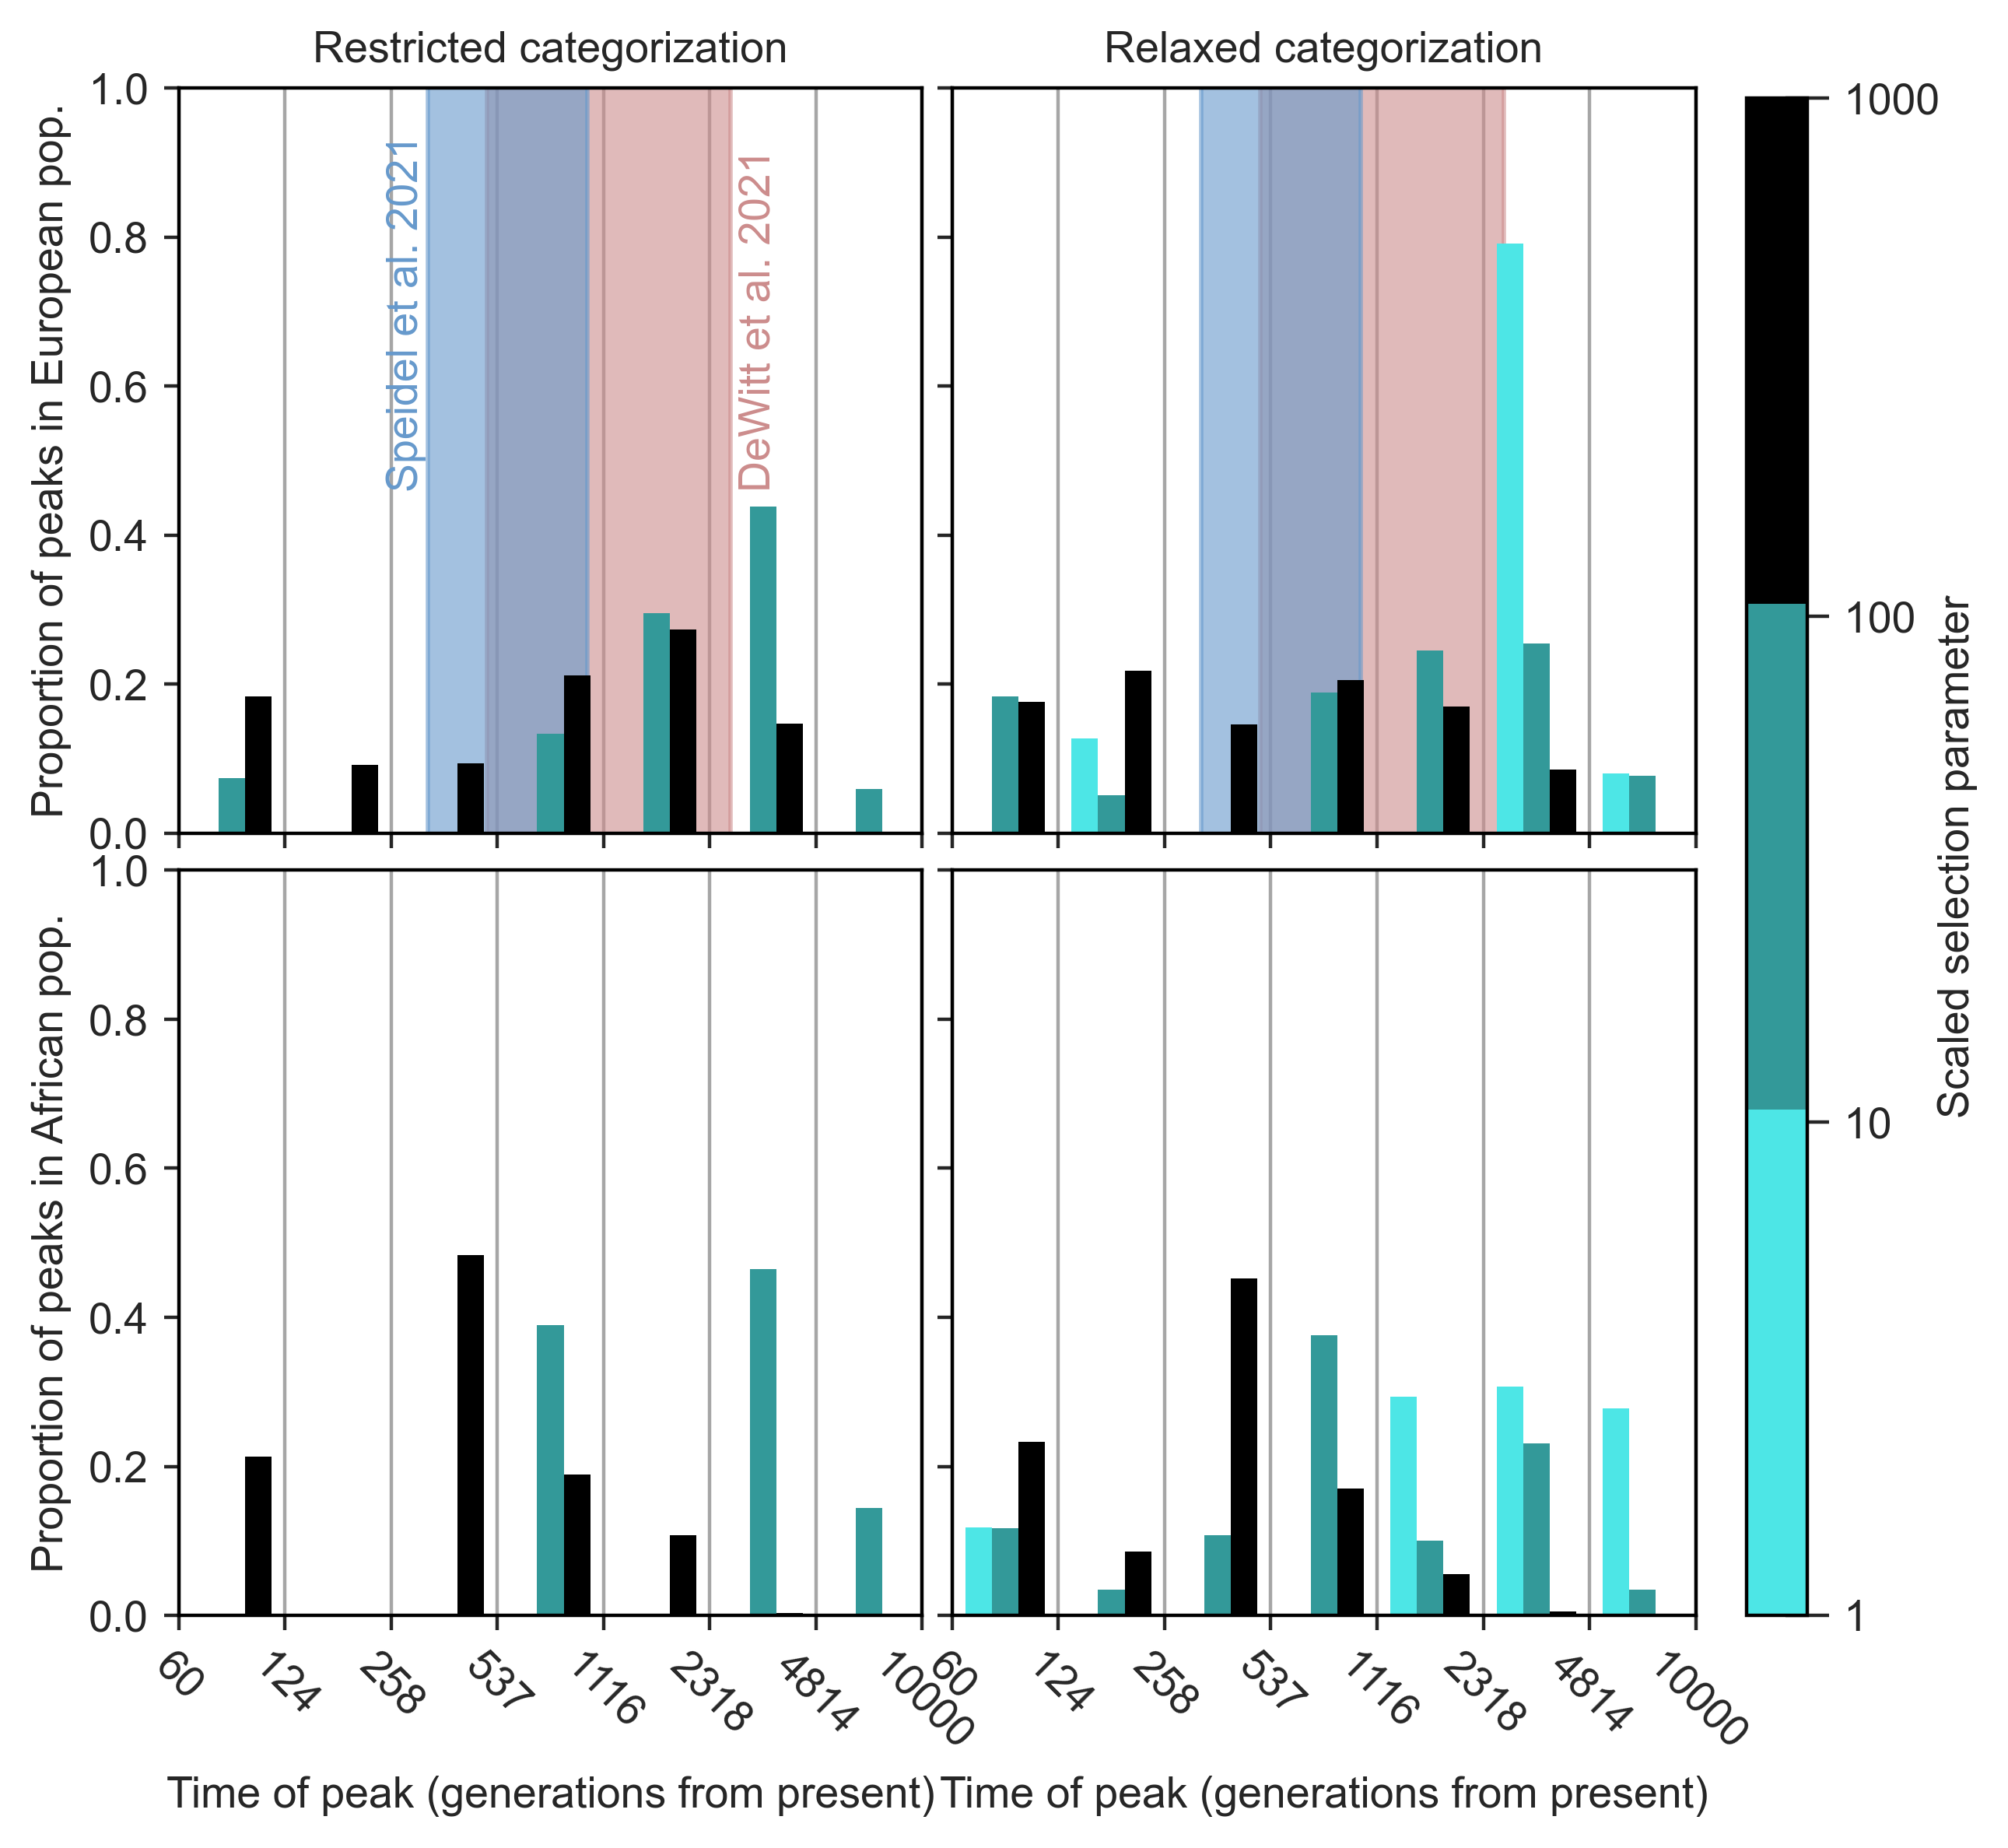

In [523]:
# FIg S18

# define number of bins and color for each bin
n_bins = 3
cmap_list = [[i/3,i,i] for i in [0.9,0.6,0]]

# plot results
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize = (6.5,6.5))
peaks_figure(fig=fig,axes=(ax1,ax3),results_raw=results,mode='restricted',cmap_list = cmap_list)
peaks_figure(fig=fig,axes=(ax2,ax4),results_raw=results,mode='relaxed',cmap_list = cmap_list)

# add plotting  details
ax2.set_yticklabels([])
ax4.set_yticklabels([])
ax1.set_ylabel('Proportion of peaks '+'in European pop.')
ax1.set_title('Restricted categorization')
ax2.set_title('Relaxed categorization')
ax3.set_ylabel('Proportion of peaks '+'in African pop.')
ax3.set_xlabel('Time of peak (generations from present)')
ax4.set_xlabel('Time of peak (generations from present)')
ax1.text(s='Speidel et al. 2021',color=[0.4,0.6,0.8],x=0.75e4/30,y=0.47,fontsize=10,rotation = 90)
ax1.text(s='DeWitt et al. 2021',color=[0.8,0.55,0.55],x=8.5e4/30,y=0.47,fontsize=10,rotation = 90)
plt.subplots_adjust(hspace=0.05,wspace=0.04,right = 0.875)

# plot colorbar
cmap_bound = mpl.colors.LinearSegmentedColormap.from_list(
                'Custom cmap', 
                 cmap_list,
                 n_bins)


bounds = np.linspace(0, n_bins, n_bins+1)
bounds[1] = 1.025
bounds[2] = 2.025
norm_bound = mpl.colors.BoundaryNorm(bounds, cmap_bound.N)
cax = plt.axes([0.9, 0.125, 0.03, 0.75])
cbl = mpl.colorbar.ColorbarBase(cax, 
                                cmap=cmap_bound,
                                norm=norm_bound,
                                orientation='vertical',
                                boundaries=bounds)
cbl.set_ticks(np.linspace(0,3,4))
cbl.ax.minorticks_off()
cbl.ax.set_yticklabels([f"{round(10**i)}" for i in np.linspace(0,3,4)])
cbl.set_label('Scaled selection parameter',labelpad = -0.5)
cbl.outline.set_edgecolor('k')
cbl.ax.tick_params(direction='inout',zorder=-1,length=10)

# plotting grid
for ax in [ax1,ax2,ax3,ax4]:
    ax.grid(color=[0.65]*3,axis='x',zorder=10)
    ax.grid(visible=False,axis='y')
    ax.set_ylim([0,1])